<a href="https://colab.research.google.com/gist/yt008/f3caa469d543da9d48efcc37558939c6/eda-modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [0]:
from google.colab import files
uploaded = files.upload()

Saving bank-additional-full.csv to bank-additional-full.csv


# EDA

In [0]:
#Load Data

df=pd.read_csv("bank-additional-full.csv",delimiter=";", converters={'martical':str,'education':str,'job':str,'month':str,'day_of_week':str,'y': str,'contact':str,'loan':str,'housing':str,'default':str,'poutcome':str,'age': int},engine='python')
df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [0]:
#missing value check

df.count()


age               41188
job               41188
marital           41188
education         41188
default           41188
housing           41188
loan              41188
contact           41188
month             41188
day_of_week       41188
duration          41188
campaign          41188
pdays             41188
previous          41188
poutcome          41188
emp.var.rate      41188
cons.price.idx    41188
cons.conf.idx     41188
euribor3m         41188
nr.employed       41188
y                 41188
dtype: int64

In [0]:
'''convert categoricalvariable to numerical 1 and 0'''
df.y=df.y.replace(to_replace=['no', 'yes'], value=[0, 1])
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


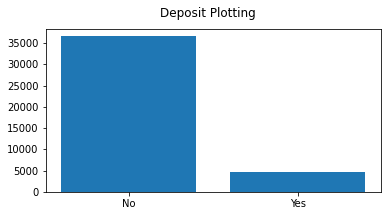

In [0]:
'''Explore distribution of opening deposit'''
values=df['y'].value_counts()
names=['No', 'Yes']
plt.figure(figsize=(6, 3))

plt.subplot()
plt.bar(names, values)

plt.suptitle('Deposit Plotting')
plt.show()

Explore Numeric variables

In [0]:
'''Visualize correlation'''
correlation = df.corr()
correlation.style.background_gradient(cmap='Purples')

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1,-0.000865705,0.00459358,-0.034369,0.0243647,-0.000370685,0.000856715,0.129372,0.0107674,-0.0177251,0.0303988
duration,-0.000865705,1,-0.0716992,-0.047577,0.0206404,-0.0279679,0.00531227,-0.00817287,-0.0328967,-0.0447032,0.405274
campaign,0.00459358,-0.0716992,1,0.0525836,-0.0791415,0.150754,0.127836,-0.0137331,0.135133,0.144095,-0.0663574
pdays,-0.034369,-0.047577,0.0525836,1,-0.587514,0.271004,0.0788891,-0.0913424,0.296899,0.372605,-0.324914
previous,0.0243647,0.0206404,-0.0791415,-0.587514,1,-0.420489,-0.20313,-0.0509364,-0.454494,-0.501333,0.230181
emp.var.rate,-0.000370685,-0.0279679,0.150754,0.271004,-0.420489,1,0.775334,0.196041,0.972245,0.90697,-0.298334
cons.price.idx,0.000856715,0.00531227,0.127836,0.0788891,-0.20313,0.775334,1,0.0589862,0.68823,0.522034,-0.136211
cons.conf.idx,0.129372,-0.00817287,-0.0137331,-0.0913424,-0.0509364,0.196041,0.0589862,1,0.277686,0.100513,0.0548779
euribor3m,0.0107674,-0.0328967,0.135133,0.296899,-0.454494,0.972245,0.68823,0.277686,1,0.945154,-0.307771
nr.employed,-0.0177251,-0.0447032,0.144095,0.372605,-0.501333,0.90697,0.522034,0.100513,0.945154,1,-0.354678


Explore Categorical variables

In [0]:
# plot distribution

def stack_bar(df: pd.DataFrame, column: str):
    labels = []
    yes = []
    no = []

    yes_dict = dict(df[df['y'] == 1][column].value_counts())

    for key, value in yes_dict.items():
        labels.append(key)
        yes.append(value)
    
    for i in labels:
        no.append(dict(df[df[column] == i][df['y'] == 0][column].value_counts())[i])

    labels.reverse()
    yes.reverse()   
    no.reverse()    

    plt.figure(figsize=(6, 4))      
    plt.barh(labels, yes, color="#ffd159", label='Yes deposit')
    plt.barh(labels, no, left=yes, color="#5fb6c7", label='No deposit')

    plt.ylabel(f'{column}')
    plt.xlabel('Number of Clients')
    plt.title('Distribution of {} and deposit'.format(column))
    plt.legend()
    plt.show();

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


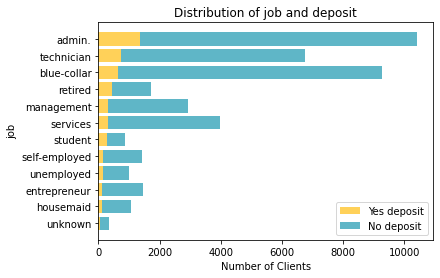

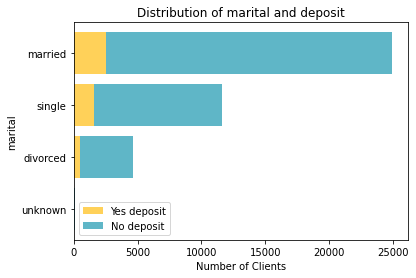

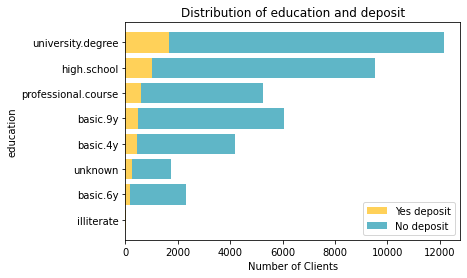

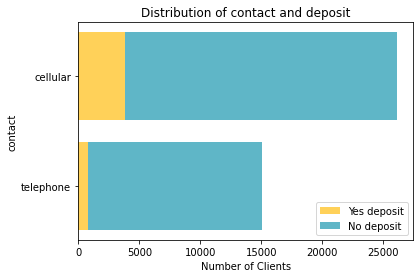

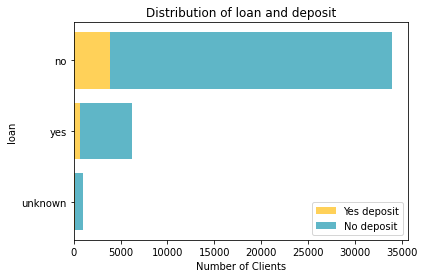

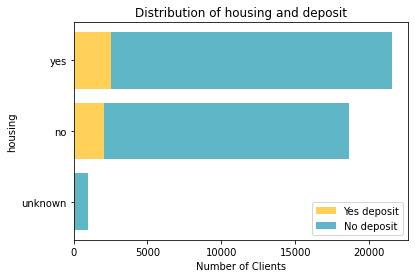

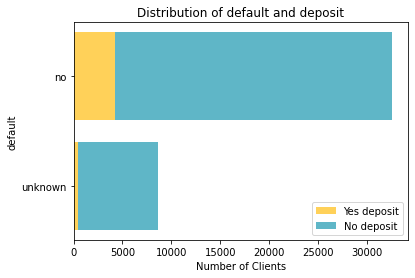

(None, None, None, None)

In [0]:
stack_bar(df, 'job'), stack_bar(df, 'marital'), stack_bar(df, 'education'), 
stack_bar(df, 'contact'), stack_bar(df, 'loan'), stack_bar(df, 'housing'), stack_bar(df, 'default')

In [0]:
#change some categorical variables into binary
df.contact=df.contact.replace(to_replace=['cellular', 'telephone'], value=[1,0])
df.loan=df.loan.replace(to_replace=['yes', 'unknown','no'], value=[1,0,0])
df.housing=df.housing.replace(to_replace=['yes', 'unknown','no'],value=[1,0,0])
df.default=df.default.replace(to_replace=['yes', 'unknown','no'],value=[1,0,0])
df.poutcome=df.poutcome.replace(to_replace=['success', 'failure','nonexistent'],value=[1,0,0])

df.head()

TypeError: ignored

In [0]:
#dummy coding some variables
df2=pd.get_dummies(df.job)
df2.head()
df3=pd.get_dummies(df.month)
df4=pd.get_dummies(df.day_of_week)
df5=pd.get_dummies(df.marital)
df6=pd.get_dummies(df.education)
df.drop(['job', 'month', 'day_of_week'], axis=1, inplace=True)

In [0]:
#Intergration of datasets
dfend=df.join(df2,how='left')
dfend2=dfend.join(df3,how="left")
dfend3=dfend2.join(df4,how="left")
dfend4=dfend3.join(df5,how="left",lsuffix='_emply',rsuffix='_marital')
dfend5=dfend4.join(df6,how="left")

dfend5.rename(columns={'unknown':'unknown_edu'}, inplace=True)
dfend5.head()

,age,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown_emply,apr,aug,dec,jul,jun,mar,may,nov,oct,sep,fri,mon,thu,tue,wed,divorced,married,single,unknown_marital,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,unknown_edu
0,56,married,basic.4y,0,0,0,0,261,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
1,57,married,high.school,0,0,0,0,149,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,37,married,high.school,0,1,0,0,226,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,40,married,basic.6y,0,0,0,0,151,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
4,56,married,high.school,0,0,1,0,307,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [0]:
#drop encoded columns
data=dfend5.drop(columns=['marital','education','default','duration'])
data.head()

,age,housing,loan,contact,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown_emply,apr,aug,dec,jul,jun,mar,may,nov,oct,sep,fri,mon,thu,tue,wed,divorced,married,single,unknown_marital,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,unknown_edu
0,56,0,0,0,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
1,57,0,0,0,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,37,1,0,0,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,40,0,0,0,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
4,56,0,1,0,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [0]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier


In [0]:
#setup grid search
n_jobs=-1
random_state=100
cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(data, data.y, test_size=0.2)
X_train.drop('y', axis=1, inplace=True)
X_test.drop('y', axis=1, inplace=True)
pipe_rf = Pipeline([('rf', RandomForestClassifier(random_state=random_state, oob_score=True, n_jobs=n_jobs))])
grid_params_rf = [{
                'rf__criterion': ['entropy'],
                'rf__min_samples_leaf': [40, 150],
                'rf__max_depth': [20, 40],
                'rf__min_samples_split': [2, 9],
                'rf__n_estimators' : [50, 100]
                }]
gs_rf = GridSearchCV(pipe_rf, param_grid=grid_params_rf,
                     scoring='accuracy', cv=cv)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
#train model and show the result
gs_rf.fit(X_train,y_train)
auc = roc_auc_score(y_test, gs_rf.predict_proba(X_test)[:,1])
print(auc)
print(gs_rf.best_params_)
print(gs_rf.best_score_)


0.8009568147645725
{'rf__criterion': 'entropy', 'rf__max_depth': 20, 'rf__min_samples_leaf': 40, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
0.8987556904400608


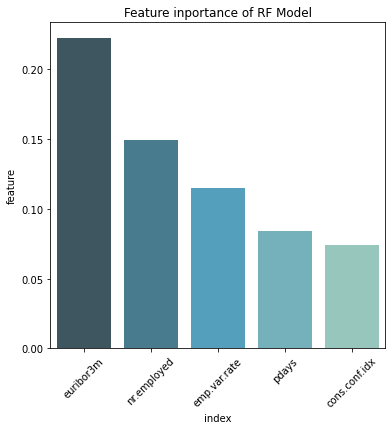

In [0]:
#visualize important features
import seaborn as sns
Feature_selection= RandomForestClassifier(criterion='entropy', random_state=11, oob_score=True, n_jobs=-1, \
                           max_depth=22, min_samples_leaf=50, min_samples_split=2, n_estimators=50)
Feature_selection.fit(X_train, y_train)
Features=pd.DataFrame(Feature_selection.feature_importances_, X_train.columns, columns=["feature"])
Features= Features.sort_values(by='feature', ascending=False).reset_index()
    
plt.figure(figsize=[6,6])
sns.barplot(x='index', y='feature', data=Features[:5], palette="GnBu_d")
plt.title('Feature inportance of RF Model')
plt.xticks(rotation=45)
plt.show();